In [1]:
 pip install medmnist

Note: you may need to restart the kernel to use updated packages.


## Download the OCTMNIST 2D dataset and prepare it for training

In [2]:
#Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from torchvision import transforms
from medmnist import OCTMNIST
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
#Import dataset
data_dir = './data'
dataset = OCTMNIST(root=data_dir, split='train', download=True, transform=transforms.ToTensor())

Using downloaded and verified file: ./data\octmnist.npz


In [4]:
#Size of the dataset
print("Size of dataset:", len(dataset))

Size of dataset: 97477


In [5]:
#Normalizing the pixel values
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = img.float() / 255.0 
        label = torch.tensor(label).long().squeeze()
        return img, label

In [6]:
#Split the dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#Data loaders
train_loader = DataLoader(CustomDataset(train_dataset), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(val_dataset), batch_size=64, shuffle=False)
test_loader = DataLoader(CustomDataset(test_dataset), batch_size=64, shuffle=False)

#Size of train, validation and test dataset
print("Size of train dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of test dataset:", len(test_dataset))

Size of train dataset: 68233
Size of validation dataset: 14621
Size of test dataset: 14623


## 1. Plain Model

In [7]:
#Neural network Plain Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
#Initialization
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(35):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Validation
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_total_correct += (outputs.argmax(1) == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_total_correct / val_total_samples
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 1.162959819099226, Train Accuracy: 0.4724693330206791, Validation Loss: 1.171418252990756, Validation Accuracy: 0.4707612338417345
Epoch 2, Train Loss: 1.1601640589905322, Train Accuracy: 0.4729090029751, Validation Loss: 1.1658333948605966, Validation Accuracy: 0.4707612338417345
Epoch 3, Train Loss: 1.1592870044060255, Train Accuracy: 0.4729090029751, Validation Loss: 1.1646387144988282, Validation Accuracy: 0.4707612338417345
Epoch 4, Train Loss: 1.1600128318398717, Train Accuracy: 0.4729090029751, Validation Loss: 1.1666681389100686, Validation Accuracy: 0.4707612338417345
Epoch 5, Train Loss: 1.159123110793524, Train Accuracy: 0.4729090029751, Validation Loss: 1.1646995052500062, Validation Accuracy: 0.4707612338417345
Epoch 6, Train Loss: 1.158147580733116, Train Accuracy: 0.4729090029751, Validation Loss: 1.1636550267710957, Validation Accuracy: 0.4707612338417345
Epoch 7, Train Loss: 1.1128875548412784, Train Accuracy: 0.5208916506675656, Validation Loss: 1

In [9]:
#Test
model.eval()
test_loss = 0.0
test_total_correct = 0
test_total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_total_correct / test_total_samples
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#Save model weights
torch.save({'SimpleCNN': model.state_dict()}, 'saved_model.pth')

#Load model weights
model = SimpleCNN()
checkpoint = torch.load('saved_model.pth')
model.load_state_dict(checkpoint['SimpleCNN'])

Test Loss: 0.7129738550779601, Test Accuracy: 0.7440333720850715


<All keys matched successfully>

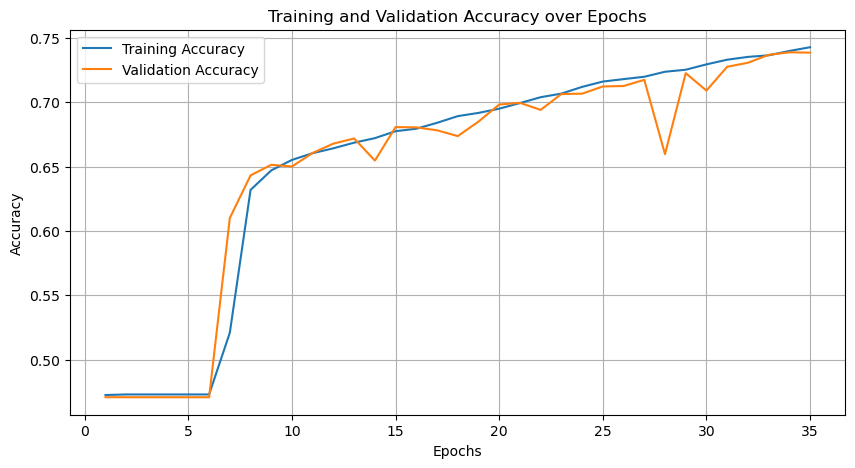

In [10]:
#Training and Validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

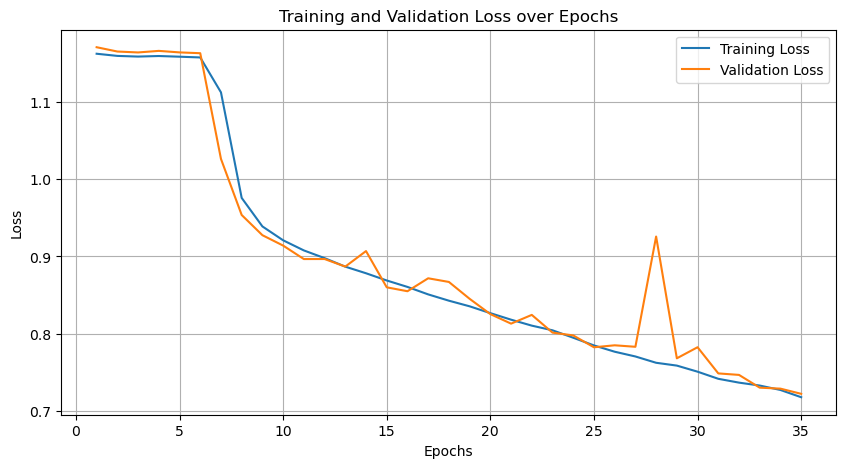

In [11]:
#Training and Validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

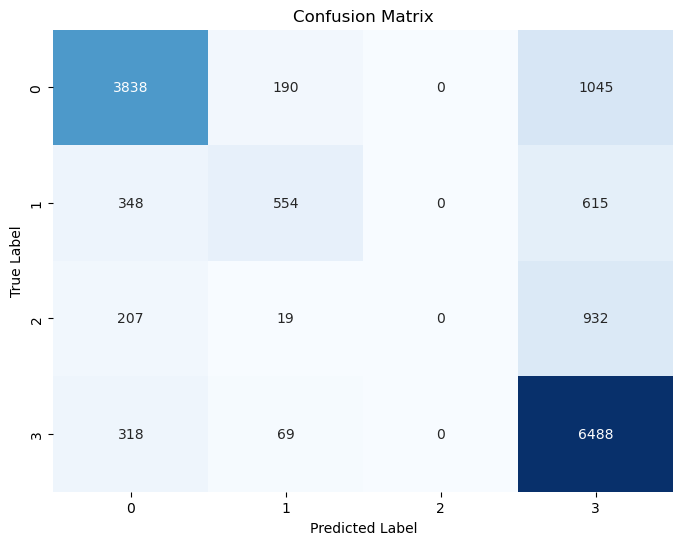

In [12]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
#Precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6876
Recall: 0.7440
F1 Score: 0.7035


C:\Users\shrig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Model with Regularization

In [14]:
#Neural network model with L2 regularization
class CNNWithL2Regularization(nn.Module):
    def __init__(self):
        super(CNNWithL2Regularization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

        # L2 regularization on all linear layers
        self.regularization = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #L2 regularization
        reg_loss = 0.0
        for param in self.regularization.parameters():
            reg_loss += torch.sum(param ** 2)  
        
        return x + reg_loss

In [15]:
#Initialization
model = CNNWithL2Regularization()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

#Training loop
for epoch in range(35):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Validation
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_total_correct += (outputs.argmax(1) == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_total_correct / val_total_samples
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 1.163425134908628, Train Accuracy: 0.47179517242390046, Validation Loss: 1.1982327413350735, Validation Accuracy: 0.4707612338417345
Epoch 2, Train Loss: 1.1614329271933244, Train Accuracy: 0.4729090029751, Validation Loss: 1.1657617079118454, Validation Accuracy: 0.4707612338417345
Epoch 3, Train Loss: 1.1601942307835107, Train Accuracy: 0.4729090029751, Validation Loss: 1.1671390801538026, Validation Accuracy: 0.4707612338417345
Epoch 4, Train Loss: 1.1597879313931023, Train Accuracy: 0.4729090029751, Validation Loss: 1.1670226368841645, Validation Accuracy: 0.4707612338417345
Epoch 5, Train Loss: 1.1494137240327622, Train Accuracy: 0.48261105330265414, Validation Loss: 1.1243768998108576, Validation Accuracy: 0.5247247110320772
Epoch 6, Train Loss: 1.0272862332495105, Train Accuracy: 0.5937449621151056, Validation Loss: 0.9668495072027481, Validation Accuracy: 0.6360714041447233
Epoch 7, Train Loss: 0.9307276159105954, Train Accuracy: 0.6518546744243987, Validat

In [16]:
#Test
model.eval()
test_loss = 0.0
test_total_correct = 0
test_total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_total_correct / test_total_samples
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#Save model weights
torch.save({'CNNWithL2Regularization': model.state_dict()}, 'saved_model_with_l2.pth')

#Load model weights
model = CNNWithL2Regularization()
checkpoint = torch.load('saved_model_with_l2.pth')
model.load_state_dict(checkpoint['CNNWithL2Regularization'])

Test Loss: 0.5139283950412117, Test Accuracy: 0.8172057717294673


<All keys matched successfully>

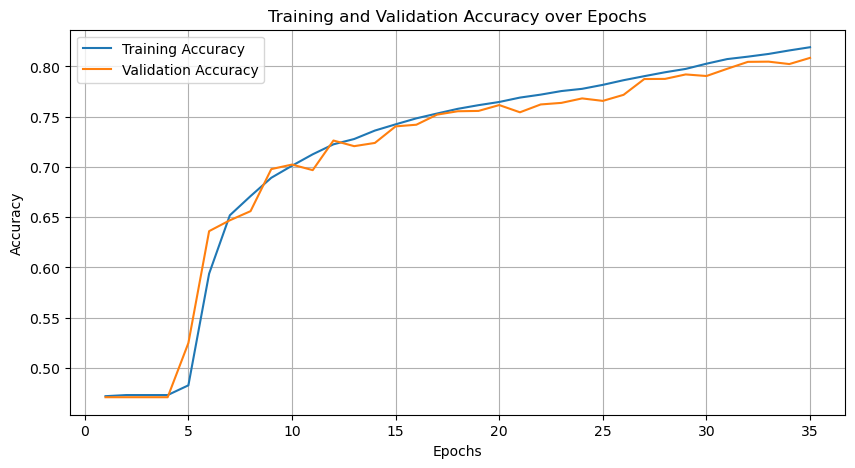

In [17]:
#Training and vVlidation accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

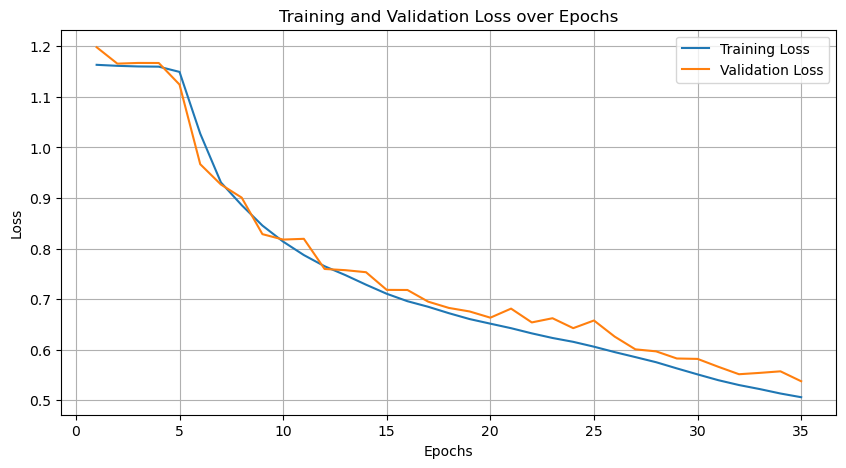

In [18]:
#Training and Validation loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

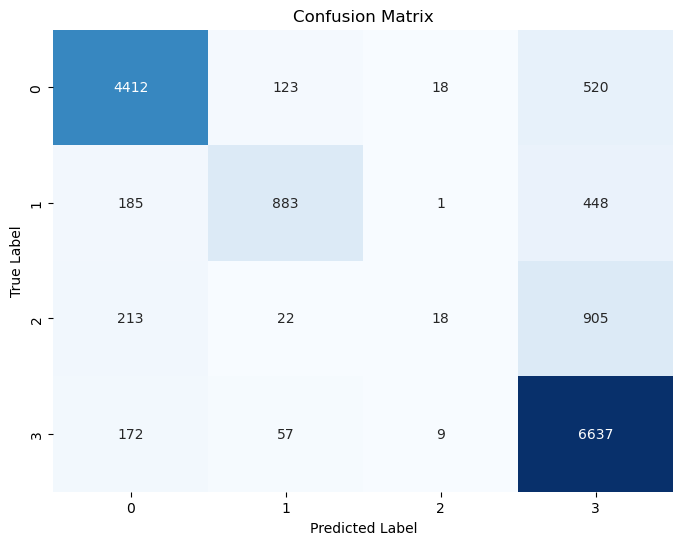

In [19]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#Precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7893
Recall: 0.8172
F1 Score: 0.7829


## 3. Model with Regularization And Dropout

In [21]:
#Neural network model with L2 regularization and dropout
class CNNWithRegularizationAndDropout(nn.Module):
    def __init__(self):
        super(CNNWithRegularizationAndDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        # L2 regularization on all linear layers
        self.regularization = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #L2 regularization
        reg_loss = 0.0
        for param in self.regularization.parameters():
            reg_loss += torch.sum(param ** 2) 
        
        return x + reg_loss

In [22]:
# Initialization
model = CNNWithRegularizationAndDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

#Training
for epoch in range(35):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Validation
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_total_correct += (outputs.argmax(1) == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_total_correct / val_total_samples
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1, Train Loss: 1.1643976053011786, Train Accuracy: 0.4713848137997743, Validation Loss: 1.2025955394886467, Validation Accuracy: 0.4707612338417345
Epoch 2, Train Loss: 1.1613805518043074, Train Accuracy: 0.4729090029751, Validation Loss: 1.173204989412466, Validation Accuracy: 0.4707612338417345
Epoch 3, Train Loss: 1.1608656124188281, Train Accuracy: 0.4729090029751, Validation Loss: 1.1667669912613114, Validation Accuracy: 0.4707612338417345
Epoch 4, Train Loss: 1.1601575119761294, Train Accuracy: 0.4729090029751, Validation Loss: 1.1747098099196323, Validation Accuracy: 0.4707612338417345
Epoch 5, Train Loss: 1.1598137351208573, Train Accuracy: 0.4729090029751, Validation Loss: 1.1674247407496756, Validation Accuracy: 0.4707612338417345
Epoch 6, Train Loss: 1.1593585254549421, Train Accuracy: 0.4729090029751, Validation Loss: 1.166285604108369, Validation Accuracy: 0.4707612338417345
Epoch 7, Train Loss: 1.1592126221107117, Train Accuracy: 0.4729090029751, Validation Loss: 1.

In [23]:
#Test
model.eval()
test_loss = 0.0
test_total_correct = 0
test_total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_total_correct / test_total_samples
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#Save model weights
torch.save({'CNNWithRegularizationAndDropout': model.state_dict()}, 'saved_model_with_reg_and_dropout.pth')

#Load model weights
model = CNNWithRegularizationAndDropout()
checkpoint = torch.load('saved_model_with_reg_and_dropout.pth')
model.load_state_dict(checkpoint['CNNWithRegularizationAndDropout'])

Test Loss: 0.961569028910591, Test Accuracy: 0.6171784175613759


<All keys matched successfully>

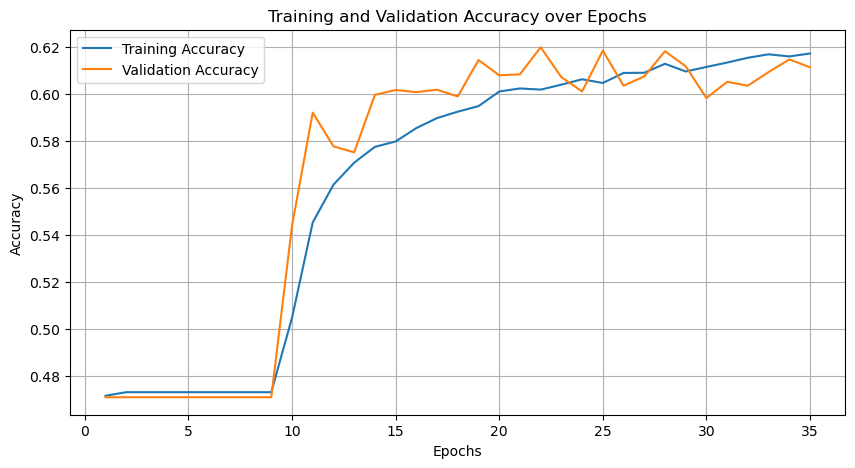

In [24]:
#Training and Validation accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

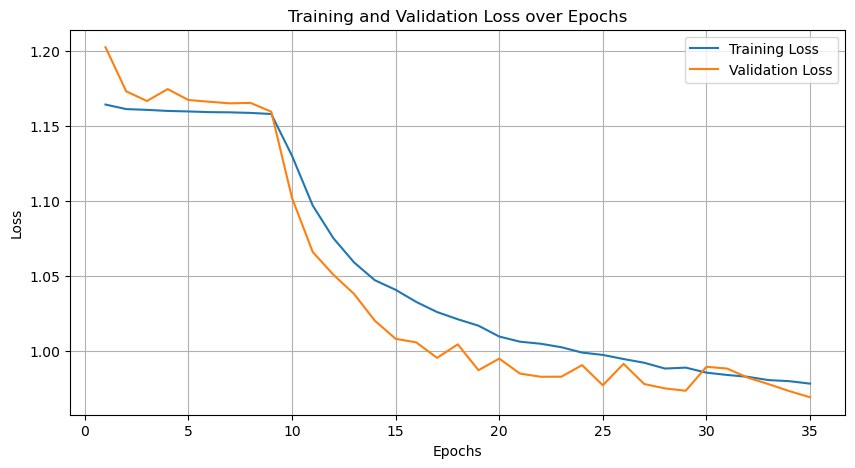

In [25]:
#Training and Validation loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

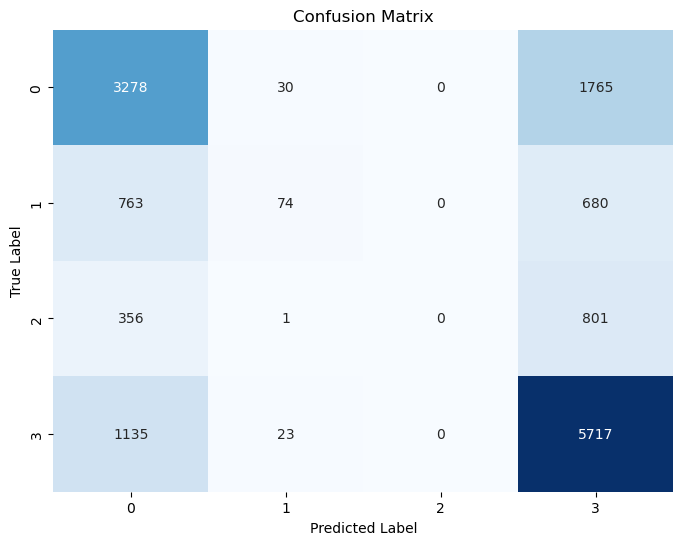

In [26]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
#Precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.5654
Recall: 0.6202
F1 Score: 0.5632


C:\Users\shrig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Final model

In [28]:
#Neural network model with L2 regularization, dropout, and early stopping
class CNNWithRegularizationDropoutAndEarlyStopping(nn.Module):
    def __init__(self):
        super(CNNWithRegularizationDropoutAndEarlyStopping, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        # L2 regularization on all linear layers
        self.regularization = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # L2 regularization
        reg_loss = 0.0
        for param in self.regularization.parameters():
            reg_loss += torch.sum(param ** 2)
        
        return x + reg_loss

In [29]:
# Initialization
model = CNNWithRegularizationDropoutAndEarlyStopping()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

early_stopping_rounds = 5  # Number of consecutive epochs to wait for validation loss improvement
best_val_loss = float('inf')  # Initialize the best validation loss

early_stopping_counter = 0
early_stopping = False

#Training
for epoch in range(35):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Validation
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_total_correct += (outputs.argmax(1) == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_total_correct / val_total_samples
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    #Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if validation loss improves
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_rounds:
            print("Early stopping triggered! Validation loss has not improved for", early_stopping_rounds, "consecutive epochs.")
            early_stopping = True
            break  # Stop training

Epoch 1, Train Loss: 1.163358729357125, Train Accuracy: 0.4724693330206791, Validation Loss: 1.1718699864424993, Validation Accuracy: 0.4707612338417345
Epoch 2, Train Loss: 1.161590624660002, Train Accuracy: 0.4729090029751, Validation Loss: 1.1826183061932893, Validation Accuracy: 0.4707612338417345
Epoch 3, Train Loss: 1.1606015418328854, Train Accuracy: 0.4729090029751, Validation Loss: 1.1743053973501947, Validation Accuracy: 0.4707612338417345
Epoch 4, Train Loss: 1.159914600480463, Train Accuracy: 0.4729090029751, Validation Loss: 1.1736823070517794, Validation Accuracy: 0.4707612338417345
Epoch 5, Train Loss: 1.1599337304990316, Train Accuracy: 0.4729090029751, Validation Loss: 1.1661182314027345, Validation Accuracy: 0.4707612338417345
Epoch 6, Train Loss: 1.159122331520052, Train Accuracy: 0.4729090029751, Validation Loss: 1.1650740897291092, Validation Accuracy: 0.4707612338417345
Epoch 7, Train Loss: 1.1590531537660171, Train Accuracy: 0.4729090029751, Validation Loss: 1.16

In [30]:
#Test
model.eval()
test_loss = 0.0
test_total_correct = 0
test_total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_total_correct / test_total_samples
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#Save model weights
torch.save({'CNNWithRegularizationDropoutAndEarlyStopping': model.state_dict()}, 'saved_model_with_reg_dropout_early_stop.pth')

#Load model weights
model = CNNWithRegularizationDropoutAndEarlyStopping()
checkpoint = torch.load('saved_model_with_reg_dropout_early_stop.pth')
model.load_state_dict(checkpoint['CNNWithRegularizationDropoutAndEarlyStopping'])

Test Loss: 0.884749976568347, Test Accuracy: 0.670929357860904


<All keys matched successfully>

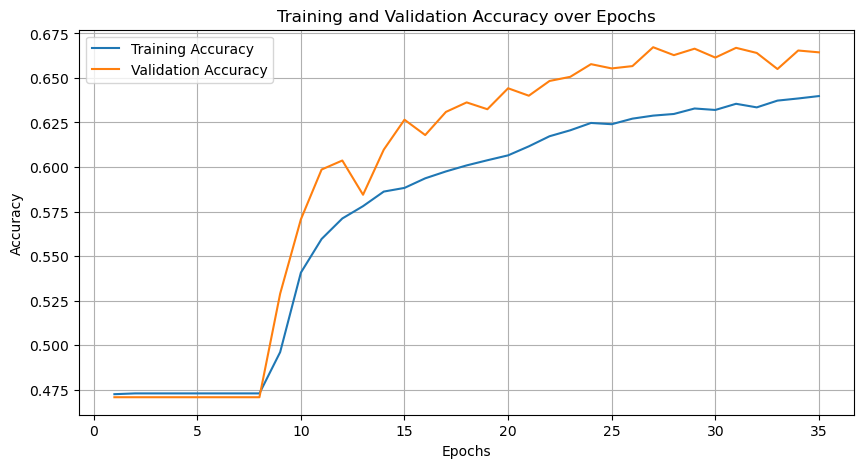

In [31]:
#Training and Validation accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

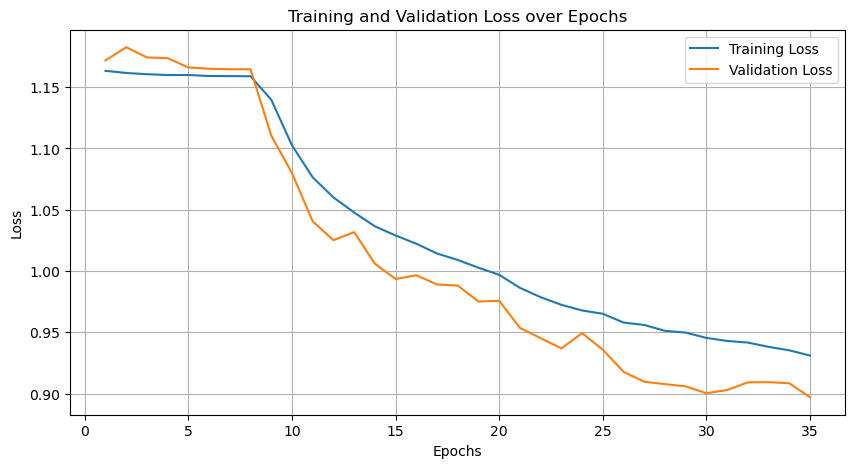

In [32]:
#Training and Validation Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

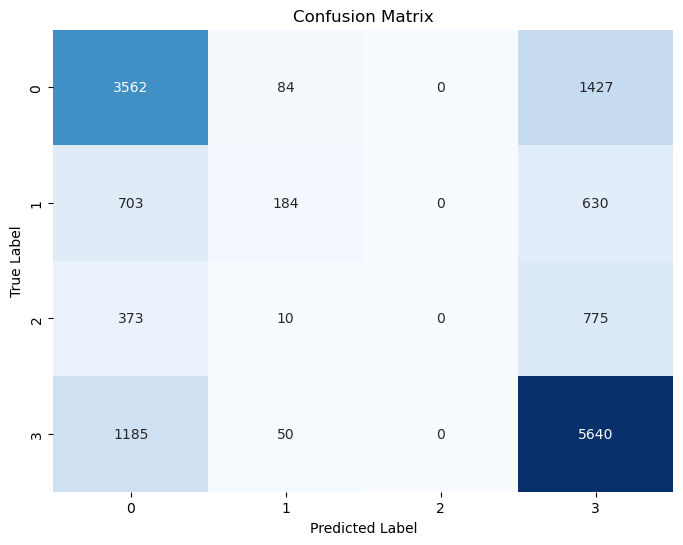

In [33]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
#Precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.5834
Recall: 0.6419
F1 Score: 0.5931


C:\Users\shrig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparison

Test Loss (before): 1.159077517850951, Test Accuracy (before): 0.47014976407030024


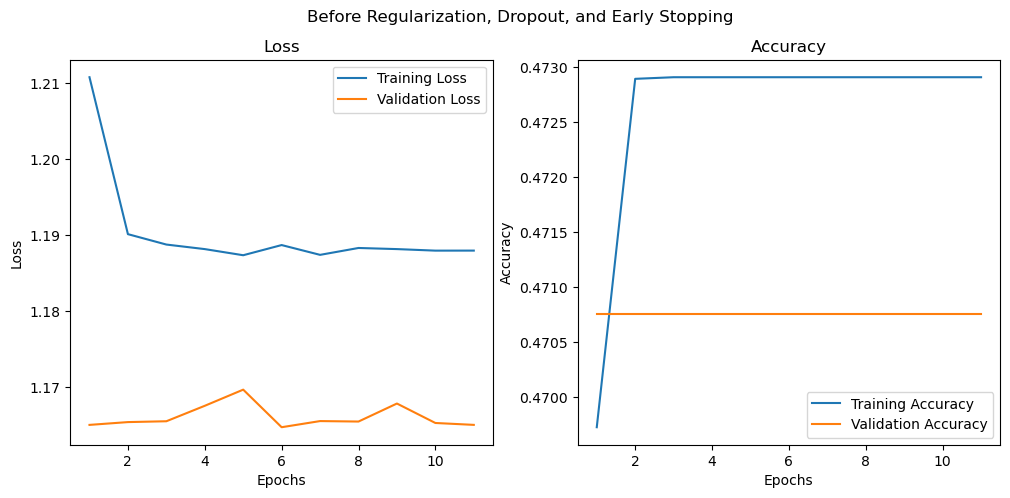

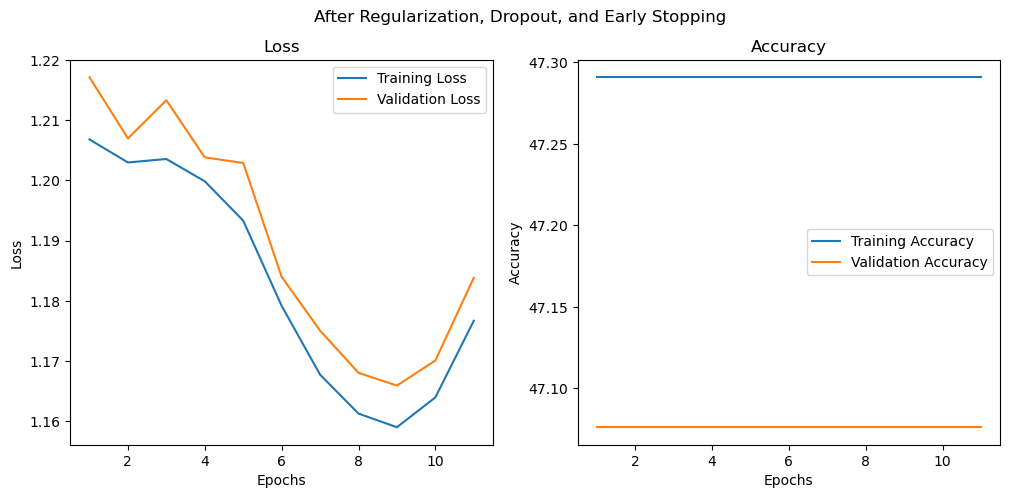

In [35]:
#Comparison
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping_rounds = 5  
best_val_loss = float('inf')

early_stopping_counter = 0
early_stopping = False

train_losses_before = []
train_accuracies_before = []
val_losses_before = []
val_accuracies_before = []

train_losses_after = []
train_accuracies_after = []
val_losses_after = []
val_accuracies_after = []

#Training
for epoch in range(35):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Apply L2 regularization
        l2_lambda = 0.01
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)

    #Validation
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_total_correct += (outputs.argmax(1) == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_total_correct / val_total_samples
    val_loss /= len(val_loader)

    if not early_stopping:
        train_losses_before.append(train_loss)
        train_accuracies_before.append(train_accuracy)
        val_losses_before.append(val_loss)
        val_accuracies_before.append(val_accuracy)

    #Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0 
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_rounds:
            early_stopping = True
            break  

#Test
model.eval()
test_loss = 0.0
test_total_correct = 0
test_total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_total_correct / test_total_samples
test_loss /= len(test_loader)

print(f"Test Loss (before): {test_loss}, Test Accuracy (before): {test_accuracy}")

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_metrics(train_losses_before, train_accuracies_before, val_losses_before, val_accuracies_before, title='Before Regularization, Dropout, and Early Stopping')

train_losses_after = []
train_accuracies_after = []
val_losses_after = []
val_accuracies_after = []

#Training 
best_model = CNN()
best_optimizer = optim.Adam(best_model.parameters(), lr=0.001)

for epoch in range(len(train_losses_before)):
    best_optimizer.zero_grad()
    best_model.train()
    for inputs, labels in train_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

    #Calculate training accuracy
    best_model.eval()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total
    train_accuracies_after.append(train_accuracy)

    #Calculate training loss
    best_model.eval()
    train_loss = 0.0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses_after.append(train_loss)

    #Calculate validation accuracy
    val_correct = 0
    val_total = 0
    for inputs, labels in val_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    val_accuracies_after.append(val_accuracy)

    #Calculate validation loss
    best_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses_after.append(val_loss)


plot_metrics(train_losses_after, train_accuracies_after, val_losses_after, val_accuracies_after, title='After Regularization, Dropout, and Early Stopping')